In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deep-learning-for-msc-202324/seqs_train.csv
/kaggle/input/deep-learning-for-msc-202324/sample.csv
/kaggle/input/deep-learning-for-msc-202324/seqs_test.csv
/kaggle/input/deep-learning-for-msc-202324/labels_train.csv
/kaggle/input/deep-learning-for-msc-202324/test/1OGQ_1_A_test.csv
/kaggle/input/deep-learning-for-msc-202324/test/1NHI_1_A_test.csv
/kaggle/input/deep-learning-for-msc-202324/test/1R1H_1_A_test.csv
/kaggle/input/deep-learning-for-msc-202324/test/1VL5_1_A_test.csv
/kaggle/input/deep-learning-for-msc-202324/test/1JLI_1_A_test.csv
/kaggle/input/deep-learning-for-msc-202324/test/1JAD_1_A_test.csv
/kaggle/input/deep-learning-for-msc-202324/test/1R73_1_A_test.csv
/kaggle/input/deep-learning-for-msc-202324/test/1WU9_1_A_test.csv
/kaggle/input/deep-learning-for-msc-202324/test/1PAQ_1_A_test.csv
/kaggle/input/deep-learning-for-msc-202324/test/1XPP_1_A_test.csv
/kaggle/input/deep-learning-for-msc-202324/test/1EZJ_1_A_test.csv
/kaggle/input/deep-learning-for-msc-202324/te

new model - with encode_amino_acid_embedding

Epoch: 1, Avg Loss: 1.1190, Avg Accuracy: 0.3449
Epoch: 2, Avg Loss: 1.1061, Avg Accuracy: 0.3465
Epoch: 3, Avg Loss: 1.1024, Avg Accuracy: 0.3471
Epoch: 4, Avg Loss: 1.1005, Avg Accuracy: 0.3480
Epoch: 5, Avg Loss: 1.0993, Avg Accuracy: 0.3490


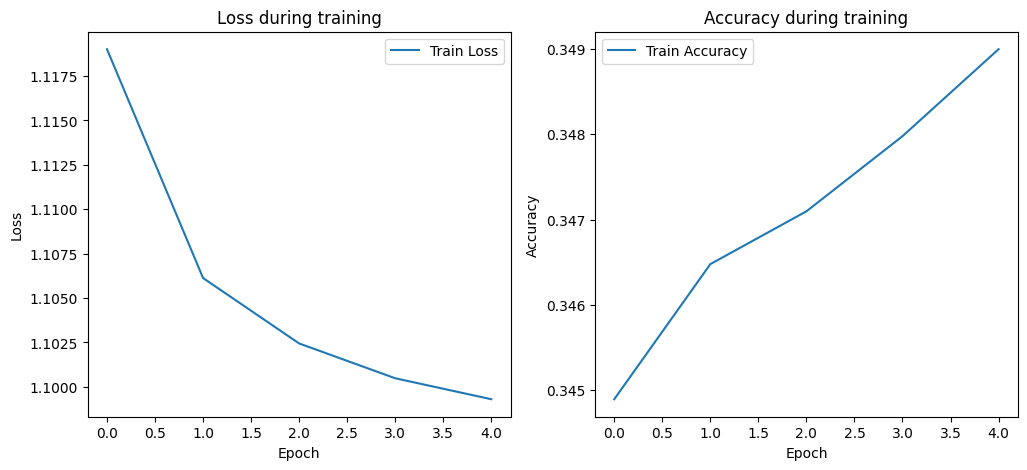

In [2]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt

# 氨基酸到索引的映射
amino_acid_to_index = {amino_acid: i for i, amino_acid in enumerate('ACDEFGHIKLMNPQRSTVWY')}
num_amino_acids = len(amino_acid_to_index)

# # 氨基酸频率字典
# amino_acid_frequencies = {'A': 0.09, 'C': 0.02, 'D': 0.05, 'E': 0.06, 'F': 0.04,
#                           'G': 0.07, 'H': 0.02, 'I': 0.06, 'K': 0.06, 'L': 0.10,
#                           'M': 0.02, 'N': 0.06, 'P': 0.05, 'Q': 0.04, 'R': 0.05,
#                           'S': 0.08, 'T': 0.06, 'V': 0.07, 'W': 0.01, 'Y': 0.03}


def encode_amino_acid_embedding(aa):
    # 将氨基酸转换为索引，对于未知氨基酸使用索引20
    index = amino_acid_to_index.get(aa, 20)  # 由于有20种已知氨基酸，未知氨基酸使用索引20
    # 返回氨基酸的独热编码向量，现在长度为21
    return np.eye(21)[index]  # 创建大小为21的单位矩阵，以匹配包括未知氨基酸的独热编码

def encode_sequence(sequence):
    # 使用列表推导式创建独热编码的NumPy数组列表
    encoded_list = [encode_amino_acid_embedding(aa) for aa in sequence]
    # 将列表转换为单一的NumPy数组
    encoded_array = np.array(encoded_list)
    # 最后，将NumPy数组转换为PyTorch张量
#     print("encoded_array shape:", encoded_array.shape)
    return torch.tensor(encoded_array, dtype=torch.float32)


# 编码标签
def encode_label(label):
    label_dict = {'H': 0, 'E': 1, 'C': 2}
    return torch.tensor([label_dict[aa] for aa in label], dtype=torch.long)

# 数据集类定义
class ProteinDataset(Dataset):
    def __init__(self, sequences_csv, labels_csv, train_dir):
        self.sequences_df = pd.read_csv(sequences_csv)
        self.labels_df = pd.read_csv(labels_csv)
        self.train_dir = train_dir

    def __getitem__(self, idx):
        pdb_id = self.sequences_df.iloc[idx]['PDB_ID']
        sequence = self.sequences_df.iloc[idx]['SEQUENCE']
        label = self.labels_df[self.labels_df['PDB_ID'] == pdb_id]['SEC_STRUCT'].values[0]

        pssm_path = os.path.join(self.train_dir, f"{pdb_id}_train.csv")
        pssm_df = pd.read_csv(pssm_path)

        sequence_encoded = encode_sequence(sequence).float()
        pssm_scores = torch.tensor(pssm_df.iloc[:, 2:].values, dtype=torch.float)
        features = torch.cat((sequence_encoded, pssm_scores), dim=1)

        label_encoded = encode_label(label)
        
#         print("Sequence encoded shape:", sequence_encoded.shape)
#         print("PSSM scores shape:", pssm_scores.shape)
#         print("Combined features shape:", features.shape)


        return features, label_encoded

    def __len__(self):
        return len(self.sequences_df)

# 自定义collate_fn
def custom_collate_fn(batch):
    sequences, labels = zip(*batch)
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=0)
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=-1).long()
    return sequences_padded, labels_padded

# 定义模型
import torch
import torch.nn as nn
import torch.optim as optim

import torch
import torch.nn as nn

import torch
import torch.nn as nn
import torch.nn.functional as F

class FullyConvNet(nn.Module):
    def __init__(self, input_channels=41, num_classes=3):
        super(FullyConvNet, self).__init__()
        # Define the convolutional layers
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        # Final layer that maps to the number of classes
        self.final_conv = nn.Conv1d(256, num_classes, kernel_size=1)

    def forward(self, x):
        
        # Apply consecutive convolutional layers
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        # No activation function is applied to the final layer
        x = self.final_conv(x)
        return x





# 训练模型
def train_model(model, train_loader, optimizer, num_classes, num_epochs=10):
    criterion = nn.CrossEntropyLoss(ignore_index=-1)  # 忽略填充位置的索引
    model.train()  # 确保模型处于训练模式
    # 准备记录损失和准确率
    train_losses = []
    train_accuracy = []
    for epoch in range(num_epochs):
        total_loss = 0
        total_correct = 0
        total_samples = 0
        
        for sequences, labels in train_loader:
            optimizer.zero_grad()
            sequences = sequences.to(device)
            sequences = sequences.permute(0, 2, 1)  # 将sequences的维度从[batch_size, sequence_length, channels]转换为[batch_size, channels, sequence_length]
            labels = labels.to(device)
            output = model(sequences)
            labels_flat = labels.view(-1)
            output_flat = output.view(-1, num_classes)
            loss = criterion(output_flat, labels_flat)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # 忽略填充位置后计算准确率
            _, predicted = torch.max(output_flat, 1)
            mask = labels_flat != -1  # 创建一个掩码，以忽略填充的位置
            total_correct += (predicted[mask] == labels_flat[mask]).sum().item()
            total_samples += mask.sum().item()
        
        avg_loss = total_loss / len(train_loader)
        avg_accuracy = total_correct / total_samples
        
        train_losses.append(avg_loss)
        train_accuracy.append(avg_accuracy)
        print(f'Epoch: {epoch+1}, Avg Loss: {avg_loss:.4f}, Avg Accuracy: {avg_accuracy:.4f}')
#         return train_losses, train_accuracy
        
    # 绘制损失和准确率曲线
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.title('Loss during training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy, label='Train Accuracy')
    plt.title('Accuracy during training')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

def calculate_accuracy(outputs, labels):
    # 将输出的logits转换为预测的类别
    _, predicted = torch.max(outputs, 1)
    # 计算正确预测的数量
    correct = (predicted == labels).sum().item()
    # 计算准确率
    accuracy = correct / labels.size(0)
    return accuracy
        
# 设置路径和参数
sequences_csv = '/kaggle/input/deep-learning-for-msc-202324/seqs_train.csv'
labels_csv = '/kaggle/input/deep-learning-for-msc-202324/labels_train.csv'
train_dir = '/kaggle/input/deep-learning-for-msc-202324/train/'

# 创建数据集、数据加载器和模型
train_dataset = ProteinDataset(sequences_csv, labels_csv, train_dir)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)

model = FullyConvNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.00002)


# 训练模型
train_model(model, train_loader, optimizer, num_classes=3, num_epochs=5)


In [3]:
def save_model_and_optimizer(model, optimizer, save_path="model_checkpoint.pth"):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, save_path)
    print(f"Model and optimizer state dicts saved to {save_path}")
    
# 保存模型和优化器的状态
save_model_and_optimizer(model, optimizer, "model_checkpoint.pth")


Model and optimizer state dicts saved to model_checkpoint.pth


In [4]:
# !pip install ax-platform


In [5]:
# pip install -U ray

In [6]:
# !pip install -U ipywidgets

In [7]:
# pip freeze | grep grpcio


In [8]:
# import os
# import pandas as pd
# import numpy as np
# import torch
# from torch.utils.data import Dataset, DataLoader
# import torch.nn as nn
# import torch.optim as optim
# from torch.nn.utils.rnn import pad_sequence
# from ray import tune
# from ray.tune import CLIReporter
# from ray.tune.schedulers import ASHAScheduler
# from sklearn.model_selection import train_test_split

# # Define the dataset class
# class ProteinDataset(Dataset):
#     def __init__(self, sequences_csv, labels_csv, train_dir):
#         self.sequences_df = pd.read_csv(sequences_csv)
#         self.labels_df = pd.read_csv(labels_csv)
#         self.train_dir = train_dir

#     def __getitem__(self, idx):
#         pdb_id = self.sequences_df.iloc[idx]['PDB_ID']
#         sequence = self.sequences_df.iloc[idx]['SEQUENCE']
#         label = self.labels_df[self.labels_df['PDB_ID'] == pdb_id]['SEC_STRUCT'].values[0]

#         pssm_path = os.path.join(self.train_dir, f"{pdb_id}_train.csv")
#         pssm_df = pd.read_csv(pssm_path)

#         sequence_encoded = encode_sequence(sequence).float()
#         pssm_scores = torch.tensor(pssm_df.iloc[:, 2:].values, dtype=torch.float)
#         features = torch.cat((sequence_encoded, pssm_scores), dim=1)

#         label_encoded = encode_label(label)
        
#         return features, label_encoded

#     def __len__(self):
#         return len(self.sequences_df)

# # Define the training function
# def train(config):
#     train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True, collate_fn=custom_collate_fn)
    
#     model = FullyConvNet(hidden_size=config["hidden_size"]).to(device)
#     optimizer = optim.Adam(model.parameters(), lr=config["lr"])

#     criterion = nn.CrossEntropyLoss(ignore_index=-1)
#     model.train()

#     for epoch in range(config["epochs"]):
#         for sequences, labels in train_loader:
#             optimizer.zero_grad()
#             sequences = sequences.to(device)
#             labels = labels.to(device)
#             output = model(sequences)
#             labels_flat = labels.view(-1)
#             output_flat = output.view(-1, 3)
#             loss = criterion(output_flat, labels_flat)
#             loss.backward()
#             optimizer.step()

#     # Evaluation
#     val_loader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False, collate_fn=custom_collate_fn)
#     model.eval()
#     val_loss = 0.0
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for sequences, labels in val_loader:
#             sequences = sequences.to(device)
#             labels = labels.to(device)
#             outputs = model(sequences)
#             _, predicted = torch.max(outputs, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#             val_loss += criterion(outputs, labels).item()

#     val_accuracy = correct / total
#     tune.report(loss=val_loss, accuracy=val_accuracy)

# # Define the search space
# search_space = {
#     "lr": tune.loguniform(1e-5, 1e-3),
#     "hidden_size": tune.choice([64, 128, 256]),
#     "batch_size": tune.choice([32, 64, 128]),
#     "epochs": 1  # 5 Reduced number of epochs for faster tuning
# }

# # Modify the local directory path to the Kaggle output directory
# local_dir = "/kaggle/working/ray_results"

# # Initialize Ray Tune with the Kaggle output directory path
# analysis = tune.run(
#     train,
#     config=search_space,
#     resources_per_trial={"gpu": 1},
#     num_samples=10,
#     scheduler=ASHAScheduler(metric="loss", mode="min"),
#     progress_reporter=CLIReporter(),
#     local_dir=local_dir  # Provide the Kaggle output directory here
# )


# # Get the best hyperparameters
# best_config = analysis.get_best_config(metric="loss", mode="min")
# print("Best hyperparameters:", best_config)


contining training for 200 times

Epoch: 1, Avg Loss: 1.0985, Avg Accuracy: 0.3494
Epoch: 2, Avg Loss: 1.0978, Avg Accuracy: 0.3495
Epoch: 3, Avg Loss: 1.0973, Avg Accuracy: 0.3507
Epoch: 4, Avg Loss: 1.0968, Avg Accuracy: 0.3505
Epoch: 5, Avg Loss: 1.0964, Avg Accuracy: 0.3513
Epoch: 6, Avg Loss: 1.0960, Avg Accuracy: 0.3524
Epoch: 7, Avg Loss: 1.0957, Avg Accuracy: 0.3526
Epoch: 8, Avg Loss: 1.0954, Avg Accuracy: 0.3520
Epoch: 9, Avg Loss: 1.0951, Avg Accuracy: 0.3528
Epoch: 10, Avg Loss: 1.0948, Avg Accuracy: 0.3531
Epoch: 11, Avg Loss: 1.0945, Avg Accuracy: 0.3548
Epoch: 12, Avg Loss: 1.0942, Avg Accuracy: 0.3539
Epoch: 13, Avg Loss: 1.0940, Avg Accuracy: 0.3550
Epoch: 14, Avg Loss: 1.0937, Avg Accuracy: 0.3549
Epoch: 15, Avg Loss: 1.0935, Avg Accuracy: 0.3561
Epoch: 16, Avg Loss: 1.0933, Avg Accuracy: 0.3569
Epoch: 17, Avg Loss: 1.0931, Avg Accuracy: 0.3570
Epoch: 18, Avg Loss: 1.0929, Avg Accuracy: 0.3582
Epoch: 19, Avg Loss: 1.0927, Avg Accuracy: 0.3570
Epoch: 20, Avg Loss: 1.0925, Avg Accuracy: 0.3585


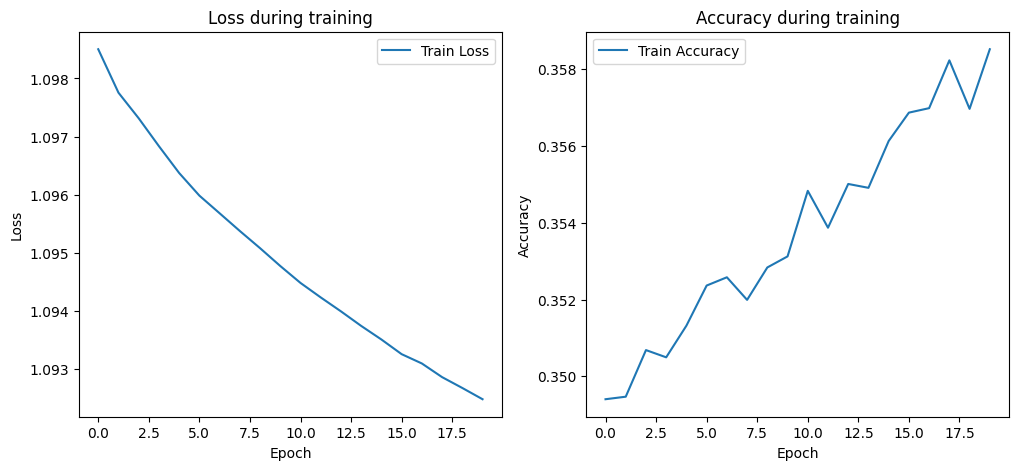

In [9]:
def load_model_and_optimizer(model, optimizer, load_path="model_checkpoint.pth"):
    checkpoint = torch.load(load_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f"Model and optimizer state dicts loaded from {load_path}")

model = FullyConvNet().to(device)  # 重新创建模型实例并移到设备上
optimizer = optim.Adam(model.parameters(), lr=1e-5)  # 重新创建优化器实例

# 加载模型和优化器状态
checkpoint = torch.load("model_checkpoint.pth", map_location=device)  # 确保加载到正确的设备
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# 对于优化器，需要手动确保优化器内部状态也在正确的设备上
for state in optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.to(device)

# 准备记录损失和准确率
train_losses = []
train_accuracy = []

# 继续训练
train_model(model, train_loader, optimizer, num_classes=3, num_epochs=20)


In [10]:
save_model_and_optimizer(model, optimizer, "model_checkpoint.pth")

Model and optimizer state dicts saved to model_checkpoint.pth


test

In [11]:
# class TestProteinDataset(Dataset):
#     def __init__(self, sequences_csv, test_dir):
#         self.sequences_df = pd.read_csv(sequences_csv)
#         self.test_dir = test_dir

#     def __getitem__(self, idx):
#         pdb_id = self.sequences_df.iloc[idx]['PDB_ID']
#         sequence = self.sequences_df.iloc[idx]['SEQUENCE']
#         sequence_file = os.path.join(self.test_dir, f"{pdb_id}_test.csv")
#         sequence_df = pd.read_csv(sequence_file)

#         test_data = sequence_df.iloc[0].values[1:]  # Excluding the first element (amino acid identifier)
#         test_data = convert_to_float(test_data)
#         test_data = torch.tensor(test_data, dtype=torch.float32)

#         sequence_tensor = encode_sequence(sequence)
#         sequence_tensor_padded = pad_sequence([sequence_tensor], batch_first=True, padding_value=0)

#         max_length = max(sequence_tensor_padded.size(1), test_data.size(0))

#         sequence_tensor_padded = F.pad(sequence_tensor_padded, (0, 0, 0, max_length - sequence_tensor_padded.size(1)), "constant", 0)
#         test_data_padded = F.pad(test_data.unsqueeze(0).unsqueeze(-1), (0, 0, 0, max_length - test_data.size(0)), "constant", 0)

#         combined_data = torch.cat((sequence_tensor_padded, test_data_padded), dim=-1)

#         return combined_data, pdb_id

#     def __len__(self):
#         return len(self.sequences_df)


# def collate_fn(batch):
#     sequences, pdb_ids = zip(*batch)
#     max_length = max(seq.size(1) for seq in sequences)
#     features_dim = sequences[0].size(2)

#     # Ensure the data type aligns with your model's expectations
#     padded_sequences = torch.zeros(len(sequences), max_length, features_dim, dtype=torch.float32)
#     for i, seq in enumerate(sequences):
#         seq_length = seq.size(1)
#         padded_sequences[i, :seq_length, :] = seq

#     print("padded_sequences:", padded_sequences.shape)

#     return padded_sequences, pdb_ids




# def predict_and_save(model, loader, device, output_file='submission.csv'):
#     model.eval()
#     predictions = []

#     with torch.no_grad():
#         for batch in loader:
#             try:
#                 sequences, pdb_ids = batch[0].to(device), batch[1]
#                 print(f"Batch sequences shape: {sequences.shape}")  # Debugging print

#                 outputs = model(sequences)
#                 _, predicted = torch.max(outputs, 2)

#                 for i, pdb_id in enumerate(pdb_ids):
#                     for residue_index, residue_prediction in enumerate(predicted[i]):
#                         prediction_label = label_dict.get(residue_prediction.item(), "Unknown")
#                         predictions.append([f'{pdb_id}_{residue_index + 1}', prediction_label])
#             except Exception as e:
#                 print(f"Error processing batch: {e}")
#                 continue  # Skip this batch and continue to the next

#     # Saving predictions to CSV...

#     # 保存到CSV文件
#     import csv
#     with open(output_file, 'w', newline='') as file:
#         writer = csv.writer(file)
#         writer.writerow(['ID', 'PREDICTION'])
#         writer.writerows(predictions)


# # 使用示例

# test_dataset = TestProteinDataset(sequences_csv='/kaggle/input/deep-learning-for-msc-202324/seqs_test.csv', test_dir='/kaggle/input/deep-learning-for-msc-202324/test/')
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

# # 假定 model, dataset, loader  已经定义
# output_path = '/kaggle/working/submission.csv'  # 确保这里使用的是你希望保存文件的确切路径
# predict_and_save(model, test_dataset, test_loader, output_path)



In [12]:
# import pandas as pd
# import torch
# import os
# import torch.nn.functional as F
# from torch.utils.data import Dataset
# from torch.nn.utils.rnn import pad_sequence


# class TestProteinDataset(Dataset):
#     def __init__(self, sequences_csv, test_dir):
#         self.sequences_df = pd.read_csv(sequences_csv)
#         self.test_dir = test_dir

#     def __getitem__(self, idx):
#         pdb_id = self.sequences_df.iloc[idx]['PDB_ID']
#         sequence = self.sequences_df.iloc[idx]['SEQUENCE']
#         sequence_file = os.path.join(self.test_dir, f"{pdb_id}_test.csv")
#         sequence_df = pd.read_csv(sequence_file)

#         test_data = sequence_df.iloc[0].values[1:]  # Excluding the first element (amino acid identifier)
#         test_data = convert_to_float(test_data)
#         test_data = torch.tensor(test_data, dtype=torch.float32).unsqueeze(0)  # Add batch dimension

#         sequence_tensor = encode_sequence(sequence)

#         # Pad or trim the sequence tensor to match the desired length (269)
#         if sequence_tensor.size(0) < 269:
#             sequence_tensor = F.pad(sequence_tensor, (0, 0, 0, 269 - sequence_tensor.size(0)), "constant", 0)
#         elif sequence_tensor.size(0) > 269:
#             sequence_tensor = sequence_tensor[:269]

#         # Expand the sequence tensor to match the desired batch size (60)
#         sequence_tensor = sequence_tensor.unsqueeze(0).expand(64, -1, -1)

#         # Adjust the sequence tensor's channel dimension to match the test_data's channel dimension
#         sequence_tensor = torch.cat((sequence_tensor, torch.zeros(64, 269, 1)), dim=-1)

#         # Remove the excess channels from sequence_tensor
#         sequence_tensor = sequence_tensor[:, :40, :20]

#         # Repeat the test data to match the desired number of channels (3)
#         test_data = test_data.repeat(64, 1, 1)

#         # Adjust the test data to match the desired shape
#         # Here, you can trim or pad the test data to match the desired shape [60, 21, 3]
#         # For example:
#         # test_data = test_data[:, :21].unsqueeze(-1).expand(-1, -1, 3)  # Trim and expand the test data
        
#         # 选择前3个特征，并假设这些是您需要的特征
# #         selected_features = test_data[:, :, :3]  # 现在形状为 [64, 1, 3]

#         # 由于我们的目标形状是 [64, 3, 40]，我们需要将这个张量重塑
#         # 注意，根据您的数据和模型需求，这里的重塑和填充操作可能需要调整
#         # 下面的步骤假设您可以通过重复或其他方式生成额外的数据以满足形状要求

#         # 重复特征以扩展序列长度维度到40
#         # 注意：这只是一种方法，具体方法取决于您的数据和模型需要
# #         expanded_data = test_data.repeat(1, 40, 1)  # 这会导致形状错误，我们只是为了演示重复的概念

#         # 使用均值来减少特征维度
#         mean_features = torch.mean(sequence_tensor, dim=-1, keepdim=True).expand(-1, -1, 3)  # 先扩展为[64, 40, 3]

        
#         print("sequence_tensor shape:", sequence_tensor.shape)
#         print("test_data shape:", test_data.shape)
#         print("mean_features shape:", mean_features.shape)

# #         # Concatenate the sequence tensor and test data along the channel dimension
# #         combined_data = torch.cat((sequence_tensor, test_data.unsqueeze(1)), dim=-1)
# #         print("combined_data shape:", combined_data.shape)
        

#         return mean_features, pdb_id

#     def __len__(self):
#         return len(self.sequences_df)




# def collate_fn(batch):
#     sequences, pdb_ids = zip(*batch)
#     max_length = max(seq.size(1) for seq in sequences)
#     features_dim = sequences[0].size(2)

#     # Ensure the data type aligns with your model's expectations
#     padded_sequences = torch.zeros(len(sequences), max_length, features_dim, dtype=torch.float32)
#     for i, seq in enumerate(sequences):
#         seq_length = seq.size(1)
#         padded_sequences[i, :seq_length, :] = seq

#     return padded_sequences, pdb_ids

# # 自定义collate_fn
# def custom_collate_fn(batch):
#     sequences, labels = zip(*batch)
#     sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=0)
#     labels_padded = pad_sequence(labels, batch_first=True, padding_value=-1).long()
#     return sequences_padded, labels_padded



# def predict_and_save(model, loader, device, output_file='submission.csv'):
#     model.eval()  # Set the model to evaluation mode.
#     predictions = []

#     with torch.no_grad():  # Turn off gradients for the following code.
#         for combined_data, pdb_ids in loader:
#             combined_data = combined_data.to(device)  # Ensure data is on the correct device.
#             combined_data = combined_data.squeeze(0)  # 去除批量维度
#             # 假设 combined_data 是您的数据张量，形状为 [64, 40, 3]
#             # 使用 .permute() 方法调整维度顺序
#             adjusted_data = combined_data.permute(0, 2, 1)

#             # 现在 adjusted_data 的形状应该是 [64, 3, 40]
#             print("Adjusted data shape: ", adjusted_data.shape)

#             # 然后将调整后的数据传入模型
#             output = model(adjusted_data)

# #             print("predict combined_data: ", combined_data.shape)
# #             print(combined_data)
# #             output = model(combined_data)  # Get model predictions.
#             _, predicted = torch.max(output, -1)  # Get the indices of max log-probability.
            
#             for i, pdb_id in enumerate(pdb_ids):
#                 sequence_predictions = predicted[i].cpu().numpy()
#                 for residue_index, residue_prediction in enumerate(sequence_predictions):
#                     prediction_label = 'H' if residue_prediction == 0 else ('E' if residue_prediction == 1 else 'C')
#                     predictions.append([f'{pdb_id}_{residue_index + 1}', prediction_label])

#     # Save predictions to CSV file.
#     with open(output_file, 'w', newline='') as file:
#         writer = csv.writer(file)
#         writer.writerow(['ID', 'PREDICTION'])
#         writer.writerows(predictions)

# # Example usage
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# # model = # Your model here

# model = FullyConvNet().to(device)  # 重新创建模型实例并移到设备上
# optimizer = optim.Adam(model.parameters(), lr=0.0001)  # 重新创建优化器实例

# # 加载模型和优化器状态
# checkpoint = torch.load("model_checkpoint.pth", map_location=device)  # 确保加载到正确的设备
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# # 对于优化器，需要手动确保优化器内部状态也在正确的设备上
# for state in optimizer.state.values():
#     for k, v in state.items():
#         if isinstance(v, torch.Tensor):
#             state[k] = v.to(device)
            
# model.to(device)
# print(model)

# test_dataset = TestProteinDataset(sequences_csv='/kaggle/input/deep-learning-for-msc-202324/seqs_test.csv', test_dir='/kaggle/input/deep-learning-for-msc-202324/test/')
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # No collate_fn needed if your Dataset and DataLoader are correctly set up.

# predict_and_save(model, test_loader, device, '/kaggle/working/submission.csv')


In [13]:
model

FullyConvNet(
  (conv1): Conv1d(41, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (final_conv): Conv1d(256, 3, kernel_size=(1,), stride=(1,))
)

In [14]:
import torch
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# 保留之前定义的encode_amino_acid和encode_sequence函数

class TestProteinDataset(Dataset):
    def __init__(self, sequences_csv, test_dir):
        self.sequences_df = pd.read_csv(sequences_csv)
        self.test_dir = test_dir

    def __getitem__(self, idx):
        pdb_id = self.sequences_df.iloc[idx]['PDB_ID']
        sequence = self.sequences_df.iloc[idx]['SEQUENCE']
        pssm_path = os.path.join(self.test_dir, f"{pdb_id}_test.csv")
        pssm_df = pd.read_csv(pssm_path)
        
        sequence_encoded = encode_sequence(sequence).float()
        pssm_scores = torch.tensor(pssm_df.iloc[:, 2:].values, dtype=torch.float)
        features = torch.cat((sequence_encoded, pssm_scores), dim=1)

        return features, pdb_id

    def __len__(self):
        return len(self.sequences_df)

def predict_collate_fn(batch):
    sequences, pdb_ids = zip(*batch)
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=0)
    return sequences_padded, pdb_ids


def predict(model, loader, device):
    model.eval()
    predictions = {}

    with torch.no_grad():
        for sequences, pdb_ids in loader:
            sequences = sequences.to(device)
            sequences = sequences.permute(0, 2, 1)  # 将sequences的维度从[batch_size, sequence_length, channels]转换为[batch_size, channels, sequence_length]

            output = model(sequences)  # 假设输出维度为 (batch_size, num_classes, sequence_length)

            # 由于batch_size=1，直接处理每个batch
            for i, pdb_id in enumerate(pdb_ids):
                output_seq = output[i]  # 输出形状应为 (num_classes, sequence_length)
                _, predicted_seq = torch.max(output_seq, dim=0)  # 对每个位置取最大值获取类别
                
                # 保存预测结果
                predictions[pdb_id] = predicted_seq.cpu().numpy()

    return predictions







# # Example usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# # 加载保存的状态字典
checkpoint = torch.load('/kaggle/working/model_checkpoint.pth')

# # 创建和加载模型
model = FullyConvNet().to(device)  # 确保使用的是正确的模型类
model.load_state_dict(checkpoint['model_state_dict'])  # 正确加载模型状态字典

# # 如果需要加载优化器状态
# optimizer = optim.Adam(model.parameters(), lr=0.0001)  # 使用与训练时相同的参数创建优化器
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])  # 加载优化器状态字典

# # model.load_state_dict(torch.load('/kaggle/working/model_checkpoint.pth'))  # Assuming 'model.pth' is your saved model

test_dataset = TestProteinDataset(sequences_csv='/kaggle/input/deep-learning-for-msc-202324/seqs_test.csv', test_dir='/kaggle/input/deep-learning-for-msc-202324/test/')
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=predict_collate_fn)

predictions = predict(model, test_loader, device)
print(len(predictions))





# 假设 predictions 字典的结构是 {pdb_id: numpy_array_of_predictions, ...}
# 其中 numpy_array_of_predictions 中的每个元素代表该残基的预测类别

# 准备写入CSV文件
import csv

# 假设您已经有一个名为predictions的字典，其中包含了蛋白质残基的预测结果

# 指定输出路径
output_path = '/kaggle/working/submission.csv'

# 打开CSV文件进行写入
with open(output_path, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['ID', 'STRUCTURE'])  # 写入头部

    # 迭代predictions字典并写入每个残基的预测
    for pdb_id, pred_labels in predictions.items():
        for residue_index, residue_prediction in enumerate(pred_labels):
            # 构建ID，格式为 "PDBID_RESIDUEINDEX"
            residue_id = f'{pdb_id}_{residue_index + 1}'

            # 将预测标签数字转换为对应的字符标签
            # 这里假设您的标签映射方式与之前提供的相同
            prediction_label = 'C' if residue_prediction == 0 else ('H' if residue_prediction == 1 else 'E')
            
            # 写入当前残基的预测
            csvwriter.writerow([residue_id, prediction_label])

print(f"Predictions have been saved to {output_path}")


205
Predictions have been saved to /kaggle/working/submission.csv
